# Importing Required Packages:

In [1]:
import glob
import os
import re
import string
import time

import contractions
import matplotlib.pyplot as plt
import nltk
import openai
import pandas as pd
import plotly.graph_objects as go
from dotenv import load_dotenv
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from plotly.subplots import make_subplots
from pydantic import BaseModel, Field, field_validator, validator
from tqdm import tqdm
from transformers import pipeline
from typing import List, Literal
from wordcloud import WordCloud
from enum import Enum

tqdm.pandas()

load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manikrishnamandepudi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manikrishnamandepudi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manikrishnamandepudi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manikrishnamandepudi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Question 1:

Use a large language model of your choice to analyse the customer side of the transcript only and:

1. Identify the sentiment (positive, negative, neutral) of the call
2. Determine call outcome (issue resolved, follow-up action needed)

In [2]:
folder_path = "../data/transcripts_v3/"
data = []

for file_path in glob.glob(os.path.join(folder_path, "*.txt")):
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
        file_name = os.path.basename(file_path)
        transcript_id = file_name.replace("transcript_", "").replace(".txt", "")
        
        member_messages = []
        for line in file_content.splitlines():
            if line.startswith("Member:"):
                member_messages.append(line.replace("Member:", "").strip())

        member_message_content = " ".join(member_messages)
        
        data.append({
            'id': transcript_id, 
            'context': file_content,
            'member_context': member_message_content
        })

transcript_data = pd.DataFrame(data)
transcript_data["id"] = transcript_data["id"].astype(int)
transcript_data = transcript_data.sort_values(["id"], ascending = True).reset_index(drop = True)
print(f"Total files read: {len(transcript_data)}")

display(transcript_data.head())

Total files read: 200


,id,context,member_context
0,0,"Member: Hi, I'm calling to get a case pre-auth...","Hi, I'm calling to get a case pre-authorized. ..."
1,1,"Member: Hi, I'm calling about a denied claim I...","Hi, I'm calling about a denied claim I receive..."
2,2,"Member: Hi, I'm calling about my recent doctor...","Hi, I'm calling about my recent doctor's visit..."
3,3,"Member: Hi, I'm calling about my recent visit ...","Hi, I'm calling about my recent visit to the d..."
4,4,"Member: Hi, I'd like to schedule an appointmen...","Hi, I'd like to schedule an appointment with a..."


In [7]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

stop_words = set(stopwords.words('english'))
processed_texts = []

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

for index, row in transcript_data.iterrows():
    text = row["member_context"]
    if pd.isnull(text) or text.strip() == '':
        processed_texts.append('')  
        continue

    text_expanded = contractions.fix(text)
    tokens = tokenizer.tokenize(text_expanded)
    tokens = [word.lower() for word in tokens if word not in string.punctuation and word.lower() not in stop_words]
    pos_tokens = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    processed_texts.append(processed_text)

transcript_data['processed_member_context'] = processed_texts

In [9]:
transcript_data

,id,context,member_context,processed_member_context
0,0,"Member: Hi, I'm calling to get a case pre-auth...","Hi, I'm calling to get a case pre-authorized. ...",hi call get case pre-authorized name emily wil...
1,1,"Member: Hi, I'm calling about a denied claim I...","Hi, I'm calling about a denied claim I receive...",hi call deny claim receive recent medical serv...
2,2,"Member: Hi, I'm calling about my recent doctor...","Hi, I'm calling about my recent doctor's visit...",hi call recent doctor's visit charge copay 50 ...
3,3,"Member: Hi, I'm calling about my recent visit ...","Hi, I'm calling about my recent visit to the d...",hi call recent visit doctor charge copay 50 su...
4,4,"Member: Hi, I'd like to schedule an appointmen...","Hi, I'd like to schedule an appointment with a...",hi would like schedule appointment specialist ...
...,...,...,...,...
195,195,"Member: Hi, I'm calling about my online servic...","Hi, I'm calling about my online service accoun...",hi call online service account trouble registe...
196,196,"Member: Hi, I'm calling to schedule an appoint...","Hi, I'm calling to schedule an appointment wit...",hi call schedule appointment specialist name e...
197,197,"Member: Hi, I'm calling to get a case pre-auth...","Hi, I'm calling to get a case pre-authorized. ...",hi call get case pre-authorized name emily wil...
198,198,"Member: Hi, I'm calling about my recent visit ...","Hi, I'm calling about my recent visit to the d...",hi call recent visit doctor's office charge co...


In [13]:
def extract_first_sentence(message):
    first_sentence = message.split('.')[0]
    return first_sentence.strip()

transcript_data['first_sentence'] = transcript_data['member_context'].apply(extract_first_sentence)

def get_categories_from_llm(unique_sentences):
    sentence_list = "\n".join(unique_sentences)
    
    prompt =f"""
            I have a list of customer concerns, each expressed as an individual sentence. Please analyze each 
            sentence carefully to identify the specific concern being expressed. Then, categorize each concern 
            in a structured manner, ensuring you capture the underlying intent. If any new categories emerge from 
            the data, please create and name them accordingly. Return the results as a list of categories only 
            (without including the sentences) that best describe the concerns expressed in each sentence.

            Sentences: {sentence_list}
            """
    
    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that categorizes sentences."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100,
        temperature=0.7
    )
    
    return response["choices"][0]["message"]["content"].strip()

unique_sentences = transcript_data['first_sentence'].unique()
categories_from_llm = get_categories_from_llm(unique_sentences)
print(f"{categories_from_llm}")

1. Pre-authorization Requests
2. Denied Claims
3. Appointment Scheduling
4. Online Account Issues
5. Billing and Payment Concerns


In [39]:
class TranscriptInput(BaseModel):
    customer_text: str = Field(..., description="Text from the customer's conversation")

    @field_validator('customer_text')
    def validate_text(cls, v):
        if len(v.strip()) == 0:
            raise ValueError("Customer text cannot be empty")
        return v

class SentimentOutcome(BaseModel):
    sentiment: Literal['Positive', 'Negative', 'Neutral'] = Field(
        ..., description="The sentiment of the customer"
    )
    sentiment_confidence: float = Field(
        ..., ge=0, le=1, description="Confidence score for sentiment"
    )
    outcome: Literal['Issue Resolved', 'Follow-up Action Needed'] = Field(
        ..., description="The call outcome"
    )
    outcome_confidence: float = Field(
        ..., ge=0, le=1, description="Confidence score for outcome"
    )
    category: Literal['Pre-authorization Requests', 'Denied Claims','Appointment Scheduling','Online Account Issues','Billing and Payment Concerns'] = Field(
        ..., description="category"
    )
    category_confidence: float = Field(
        ..., ge=0, le=1, description="Confidence score for category"
    )

    @field_validator('sentiment_confidence', 'outcome_confidence','category_confidence')
    def validate_confidence(cls, v):
        if not 0 <= v <= 1:
            raise ValueError("Confidence scores must be between 0 and 1.")
        return v

In [41]:
def analyze_sentiment_and_outcome(customer_text: str, max_retries=3, retry_delay=1):
    input_data = TranscriptInput(customer_text=customer_text)
    messages = [
        {
            "role": "system",
            "content": (
                "You are a customer support assistant. Analyze the sentiment, outcome, and category "
                "of the customer conversation. Focus only on the customer's side of the conversation. "
                "You must strictly classify the sentiment as either 'Positive', 'Negative', or 'Neutral'; "
                "the outcome as either 'Issue Resolved' or 'Follow-up Action Needed'; and category as either "
                "'Pre-authorization Requests', 'Denied Claims', 'Appointment Scheduling', 'Online Account Issues', or 'Billing and Payment Concerns'. "
                "For each, provide a confidence score between 0 and 1 indicating your certainty. Please provide the analysis in the following format:\n\n"
                "- **Sentiment:** [Positive/Negative/Neutral] (Confidence: [confidence score between 0 and 1])\n"
                "- **Outcome:** [Issue Resolved/Follow-up Action Needed] (Confidence: [confidence score between 0 and 1])\n"
                "- **Category:** [category name] (Confidence: [confidence score between 0 and 1])"
            )
        },
        {
            "role": "user",
            "content": f"""
Here is one example of customer conversations with a member:

**Example:**

Conversation: Hi, I'm calling to schedule an appointment with a specialist. My name is Emily Wilson and my member ID is MEM234567.
It's March 12, 1985. I need to see a cardiologist. I'd like to schedule it for next Wednesday or Thursday. I'd like to schedule 
with Dr. Johnson at 2:00 PM. Thanks for your help!

**Analysis:**

- **Sentiment:** Positive (Confidence: 0.95)
- **Outcome:** Issue Resolved (Confidence: 0.98)
- **Category:** Appointment Scheduling (Confidence: 0.97)

Now, analyze the following transcript (only the customer's conversation) to determine the sentiment, call outcome, category, and confidence values:

**Conversation:** {input_data.customer_text}

**What is the sentiment, call outcome, category, and confidence values?**
"""
        }
    ]

    retries = 0
    while retries < max_retries:
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4-turbo",
                messages=messages,
                max_tokens=200,  
                temperature=0.7
            )
            analysis_content = response['choices'][0]['message']['content'].strip()

            sentiment_match = re.search(
                r'\*\*Sentiment:\*\*\s*(Positive|Negative|Neutral)\s*\(Confidence:\s*([\d\.]+)\)',
                analysis_content
            )
            outcome_match = re.search(
                r'\*\*Outcome:\*\*\s*(Issue Resolved|Follow-up Action Needed)\s*\(Confidence:\s*([\d\.]+)\)',
                analysis_content
            )
            category_match = re.search(
                r'\*\*Category:\*\*\s*([\w\s\-]+)\s*\(Confidence:\s*([\d\.]+)\)',
                analysis_content
            )

            if sentiment_match and outcome_match and category_match:
                sentiment = sentiment_match.group(1).strip()
                sentiment_confidence = float(sentiment_match.group(2).strip())

                outcome = outcome_match.group(1).strip()
                outcome_confidence = float(outcome_match.group(2).strip())

                category = category_match.group(1).strip()
                category_confidence = float(category_match.group(2).strip())

                sentiment_outcome = SentimentOutcome(
                    sentiment=sentiment,
                    sentiment_confidence=sentiment_confidence,
                    outcome=outcome,
                    outcome_confidence=outcome_confidence,
                    category=category,
                    category_confidence=category_confidence
                )

                return sentiment_outcome

            else:
                print("Failed to parse the assistant's response.")
                return None

        except openai.error.RateLimitError as e:
            retries += 1
            print(f"Rate limit reached. Retrying in {retry_delay} seconds... (Attempt {retries}/{max_retries})")
            time.sleep(retry_delay)
            retry_delay *= 2  

        except Exception as e:
            print(f"An error occurred: {e}")
            break

    print(f"Failed after {max_retries} retries due to rate limit or other errors.")
    return None

In [46]:
def process_member_context(text):
    result = analyze_sentiment_and_outcome(customer_text=text)
    print(result)
    if result is not None:
        return pd.Series({
            'sentiment': result.sentiment,
            'sentiment_confidence': result.sentiment_confidence,
            'outcome': result.outcome,
            'outcome_confidence': result.outcome_confidence,
            'category': result.category,
            'category_confidence': result.category_confidence
        })
    else:
        return pd.Series({
            'sentiment': None,
            'sentiment_confidence': None,
            'outcome': None,
            'outcome_confidence': None,
            'category': None,
            'category_confidence': None
        })

transcript_data[['sentiment', 'sentiment_confidence', 'outcome', 'outcome_confidence', 'category', 'category_confidence']] = transcript_data['member_context'].apply(process_member_context)

sentiment='Positive' sentiment_confidence=0.9 outcome='Follow-up Action Needed' outcome_confidence=0.85 category='Pre-authorization Requests' category_confidence=0.98
sentiment='Negative' sentiment_confidence=0.9 outcome='Follow-up Action Needed' outcome_confidence=0.85 category='Denied Claims' category_confidence=0.99
sentiment='Positive' sentiment_confidence=0.9 outcome='Follow-up Action Needed' outcome_confidence=0.95 category='Billing and Payment Concerns' category_confidence=0.98
sentiment='Negative' sentiment_confidence=0.98 outcome='Follow-up Action Needed' outcome_confidence=0.95 category='Billing and Payment Concerns' category_confidence=0.99
sentiment='Positive' sentiment_confidence=0.95 outcome='Issue Resolved' outcome_confidence=0.9 category='Appointment Scheduling' category_confidence=0.98
sentiment='Positive' sentiment_confidence=0.9 outcome='Follow-up Action Needed' outcome_confidence=0.95 category='Pre-authorization Requests' category_confidence=0.99
sentiment='Positive

# Question 2:

Use appropriate metrics to monitor the performance of your model.

Since our Transcripts are not labelled. So, first annotator and first label the data

In [58]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

label_mapping = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

def classify_sentiment(text):
    scores = sentiment_pipeline(text)
    label = scores[0]['label']
    sentiment = label_mapping.get(label, 'unknown')
    return sentiment

transcript_data['roberta_sentiment'] = transcript_data['processed_member_context'].apply(classify_sentiment)

In [64]:
roberta_sentiments = transcript_data['roberta_sentiment'].tolist()
true_sentiments = transcript_data['sentiment'].tolist()

smoothie = SmoothingFunction().method4
bleu_score = sentence_bleu([roberta_sentiments], true_sentiments, smoothing_function=smoothie)

print(f"BLEU Score for sentiment comparison: {round(bleu_score,2)}")

BLEU Score for sentiment comparison: 0.69


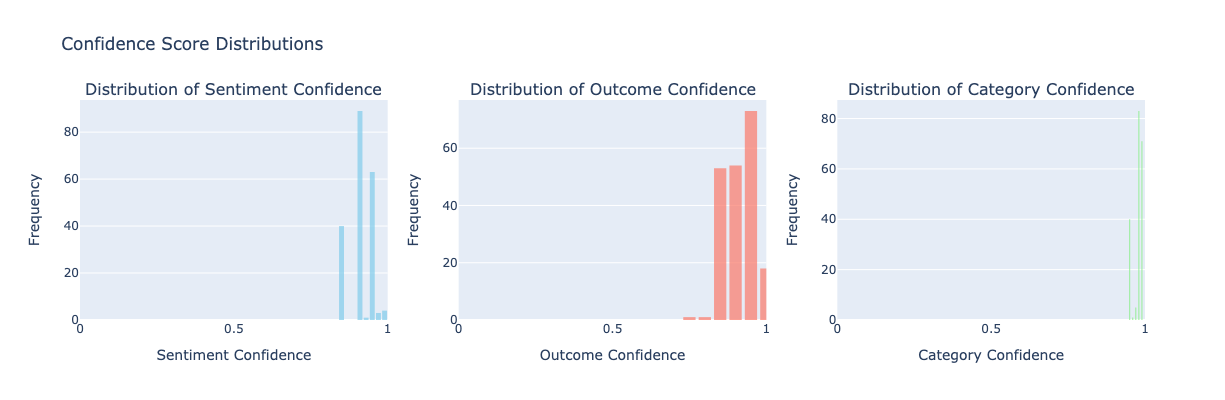

In [74]:
sentiment_confidence = transcript_data['sentiment_confidence'].dropna()
outcome_confidence = transcript_data['outcome_confidence'].dropna()
category_confidence = transcript_data['category_confidence'].dropna()

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        'Distribution of Sentiment Confidence',
        'Distribution of Outcome Confidence',
        'Distribution of Category Confidence'
    )
)

fig.add_trace(
    go.Histogram(
        x=sentiment_confidence,
        nbinsx=10,
        marker_color='skyblue',
        opacity=0.75,
        name='Sentiment Confidence',
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=outcome_confidence,
        nbinsx=10,
        marker_color='salmon',
        opacity=0.75,
        name='Outcome Confidence',
    ),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(
        x=category_confidence,
        nbinsx=10,
        marker_color='lightgreen',
        opacity=0.75,
        name='Category Confidence',
    ),
    row=1, col=3
)

for i in range(1, 4):
    fig.update_xaxes(range=[0, 1], row=1, col=i)
    fig.update_yaxes(title_text='Frequency', row=1, col=i)

fig.update_xaxes(title_text='Sentiment Confidence', row=1, col=1)
fig.update_xaxes(title_text='Outcome Confidence', row=1, col=2)
fig.update_xaxes(title_text='Category Confidence', row=1, col=3)

fig.update_layout(
    title_text='Confidence Score Distributions',
    bargap=0.2,
    width=1200,
    height=400,
    showlegend=False,
)

fig.show()

# Question 3:

Use methods of your choice (e.g. exploratory data analysis, statistical methods, visualisations etc.)  to extract useful insights from the data. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



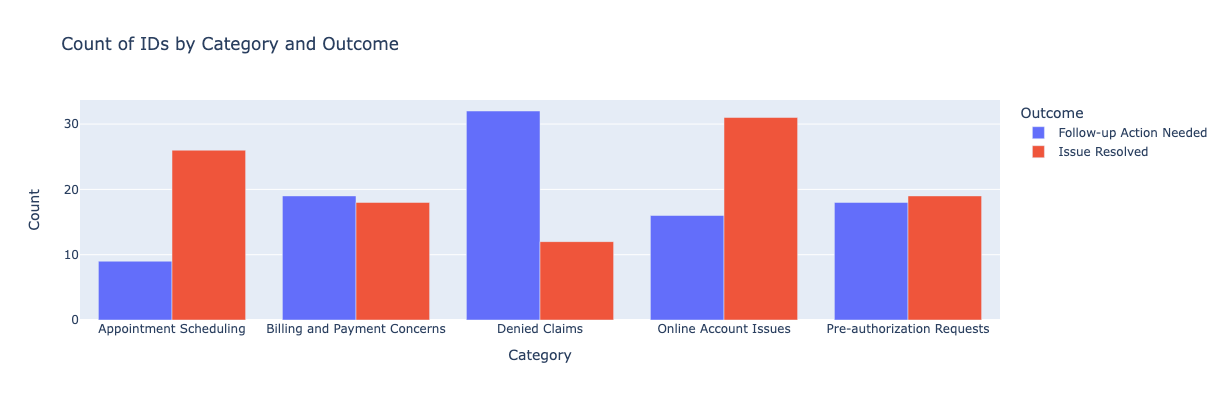

In [100]:
grouped_data = transcript_data.groupby(["category", "outcome"])["id"].count().reset_index()

fig = px.bar(
    grouped_data,
    x='category',
    y='id',
    color='outcome',
    barmode='group',
    title='Count of IDs by Category and Outcome',
    labels={'id': 'Count', 'category': 'Category', 'outcome': 'Outcome'}
)

fig.update_layout(
    xaxis_tickangle=0,
    width=1200,
    height=400
)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



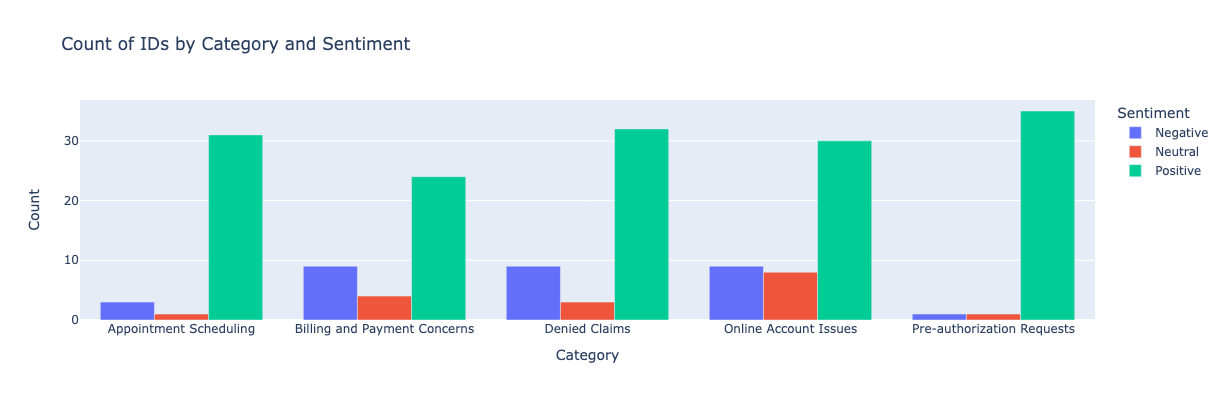

In [89]:
grouped_data = transcript_data.groupby(["category", "sentiment"])["id"].count().reset_index()

fig = px.bar(
    grouped_data,
    x='category',
    y='id',
    color='sentiment',
    barmode='group',
    title='Count of IDs by Category and Sentiment',
    labels={'id': 'Count', 'category': 'Category', 'sentiment': 'Sentiment'}
)

fig.update_layout(
    xaxis_tickangle=-0,
    width=1200,
    height=400
)

fig.show()

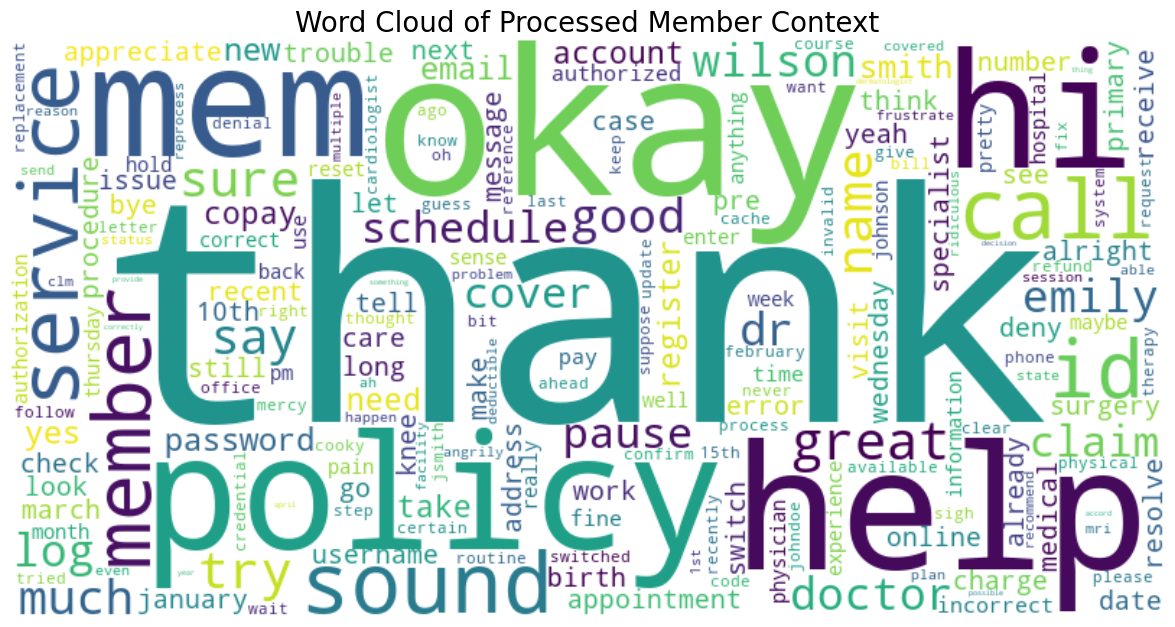

In [101]:
text = ' '.join(transcript_data['processed_member_context'].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False 
).generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Member Context', fontsize=20)
plt.show()
